In [8]:
import os
import shutil
import h5py
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from keras.models import Model
from keras.layers import Input, Dropout, Dense, Lambda
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16, resnet50, inception_v3, xception, inception_resnet_v2
from time import time

import pydot
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')


%matplotlib inline

In [ ]:
# 创建文件目录
os.mkdir('dataset/train_diff')
os.mkdir('dataset/train_diff/cat')
os.mkdir('dataset/train_diff/dog')

os.mkdir('dataset/test2')
os.mkdir('dataset/test2/test')

In [ ]:
# train中的文件
image_names_train = os.listdir('dataset/train')
print(image_names_train[:5])
print(len(image_names_train))

In [ ]:
# 将train中的图像文件移动到train_diff下对应的目录中
for image_name in image_names_train:
    src = 'dataset/train/' + image_name
    if image_name[:3] == 'cat':
        dst_cat = 'dataset/train_diff/cat/' + image_name
        shutil.move(src, dst_cat)
    else:
        dst_dog = 'dataset/train_diff/dog/' + image_name
        shutil.move(src, dst_dog)

In [ ]:
# 将test中的图像文件移动到test2/test中
image_names_test = os.listdir('dataset/test')

for image_name in image_names_test:
    src = 'dataset/test/' + image_name
    dst = 'dataset/test2/test/' + image_name
    shutil.move(src, dst)

In [3]:
# 验证一下结果
# assert len(os.listdir('dataset/train')) == 0
assert len(os.listdir('dataset/train_diff/cat')) == 12500
assert len(os.listdir('dataset/train_diff/dog')) == 12500
# assert len(os.listdir('dataset/test')) == 0
assert len(os.listdir('dataset/test2/test')) == 12500

In [4]:
# 读取异常值
with open('outliers.txt', 'r') as txtf:
    lines = txtf.read()
    
outlier_images = lines.split(',')
print(len(outlier_images))
print(outlier_images)

45
['cat.9983.jpg', 'cat.10365.jpg', 'cat.12476.jpg', 'cat.5418.jpg', 'cat.4688.jpg', 'cat.7564.jpg', 'cat.12272.jpg', 'cat.2939.jpg', 'cat.6348.jpg', 'cat.7377.jpg', 'cat.8921.jpg', 'cat.4308.jpg', 'cat.8470.jpg', 'cat.11184.jpg', 'cat.10029.jpg', 'cat.8456.jpg', 'cat.5974.jpg', 'cat.10712.jpg', 'cat.11039.jpg', 'cat.10536.jpg', 'cat.1139.jpg', 'cat.2520.jpg', 'cat.3672.jpg', 'dog.1194.jpg', 'dog.6725.jpg', 'dog.2339.jpg', 'dog.9517.jpg', 'dog.10237.jpg', 'dog.6475.jpg', 'dog.5604.jpg', 'dog.10161.jpg', 'dog.10801.jpg', 'dog.1773.jpg', 'dog.11299.jpg', 'dog.2614.jpg', 'dog.7706.jpg', 'dog.4507.jpg', 'dog.11437.jpg', 'dog.2422.jpg', 'dog.1625.jpg', 'dog.7076.jpg', 'dog.4367.jpg', 'dog.4218.jpg', 'dog.12376.jpg', 'dog.8736.jpg']


In [5]:
# 删除异常值
count = 0
for img_name in outlier_images:
    if img_name:
        img_path = 'dataset/train_diff/' + img_name[:3] + '/' + img_name
        os.remove(img_path)
        count += 1
count

45

In [6]:
len(os.listdir('dataset/train_diff/cat'))

12477

In [7]:
len(os.listdir('dataset/train_diff/dog'))

12478

In [ ]:
# 删除异常值
# count = 0
# for img_name in outlier_images:
#     try:
#         img_path = 'dataset/train_diff/' + img_name[:3] + '/' + img_name
#         os.remove(img_path)
#         count += 1
#     except:
#         pass
# count

In [8]:
assert len(os.listdir('dataset/train_diff/cat')) + len(os.listdir('dataset/train_diff/dog')) == 25000 - count

## Extract Model features without data augmentation

In [ ]:
# 导出模型的特征向量，注意文件的层级结构
def get_model(model, image_size, preprocess_func, model_name):
    # model like vgg16.VGG16
    # image_size: a tuple with image height and width
    # preprocess_func like vgg16.preprocess_input
    # model_name: string of model name
    x = Input(shape=(image_size[0], image_size[1], 3))
    x = Lambda(preprocess_func)(x)
    base_model = model(include_top=False, input_tensor=x, weights='imagenet', pooling='avg')

    image_generator = ImageDataGenerator()
    train_generator = image_generator.flow_from_directory('dataset/train_diff', target_size=image_size, 
                                                          class_mode='binary', shuffle=False, batch_size=16)
    test_generator = image_generator.flow_from_directory('dataset/test2', target_size=image_size, 
                                                         class_mode=None, shuffle=False, batch_size=16)

    train = base_model.predict_generator(train_generator)
    test = base_model.predict_generator(test_generator)

    with h5py.File('%s_gap.h5' % model_name) as h:
        h.create_dataset('train', data=train)
        h.create_dataset('test', data=test)
        h.create_dataset('labels', data=train_generator.classes)

In [ ]:
# 导出VGG16的model
start_time = time()
get_model(vgg16.VGG16, (224,224), vgg16.preprocess_input, 'VGG16')
print('VGG16 Time: {}s'.format(round(time() - start_time, 1)))

In [ ]:
# 导出ResNet50的model
start_time = time()
get_model(resnet50.ResNet50, (224,224), resnet50.preprocess_input, 'ResNet50')
print('ResNet50 Time: {}s'.format(round(time() - start_time, 1)))

In [ ]:
# 导出InceptionV3的model
start_time = time()
get_model(inception_v3.InceptionV3, (299,299), inception_v3.preprocess_input, 'InceptionV3')
print('InceptionV3 Time: {}s'.format(round(time() - start_time, 1)))

In [ ]:
# 导出Xception的model
start_time = time()
get_model(xception.Xception, (299,299), xception.preprocess_input, 'Xception')
print('Xception Time: {}s'.format(round(time() - start_time, 1)))

In [ ]:
# 导出InceptionResNetV2的model
start_time = time()
get_model(inception_resnet_v2.InceptionResNetV2, (299,299), inception_resnet_v2.preprocess_input, 'InceptionResNetV2')
print('InceptionResNetV2 Time: {}s'.format(round(time() - start_time, 1)))

In [4]:
# 单模型  VGG16
with h5py.File('extract_features/VGG16_gap.h5', 'r') as h:
    x_train = np.array(h['train'])
    x_test = np.array(h['test'])
    y_train = np.array(h['labels'])
    
x_train, y_train = shuffle(x_train, y_train)
print(x_train.shape, y_train.shape)
    
# 创建模型
input_tensor = Input(x_train.shape[1:])
x = Dropout(0.2)(input_tensor)
x = Dense(1, activation='sigmoid')(x)

model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

history_vgg = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

(25000, 512) (25000,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
None
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 66us/step - loss: 0.2906 - acc: 0.9289 - val_loss: 0.0844 - val_acc: 0.9760
Epoch 2/10
20000/20000 [==============================] - 1s 56us/step - loss: 0.0958 - acc: 0.9715 - val_loss: 0.0646 - val_acc: 0.9794
Epoch 3/10
20000/20000 [==============================] - 

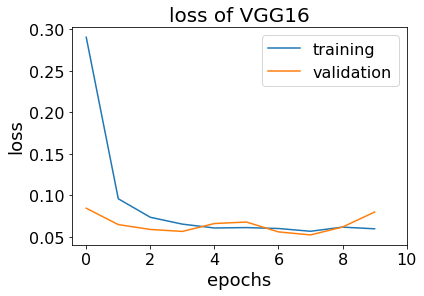

In [6]:
# 绘制训练和验证的损失曲线
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])

plt.legend(['training', 'validation'], loc='upper right', fontsize=16)

plt.title('loss of VGG16', fontsize=20)
plt.xlabel('epochs', fontsize=18)
plt.ylabel('loss', fontsize=18)

plt.xticks(range(0, 11, 2), fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [7]:
# VGG16
y_pred = model.predict(x_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv('result_csv/sample_submission.csv')

image_generator = ImageDataGenerator()

test_generator = image_generator.flow_from_directory('dataset/test2', target_size=(224, 224), 
                                                     class_mode=None, shuffle=False, batch_size=16)

for i, filename in enumerate(test_generator.filenames):
    idx = filename[filename.find('/')+1 : filename.find('.')]
    df.set_value(int(idx)-1, 'label', y_pred[i])

df.to_csv('result_csv/pred_vgg16.csv', index=False)
# score 0.08553

12500/12500 [==============================] - 0s 18us/step
Found 12500 images belonging to 1 classes.


In [10]:
# 单模型  Xception
with h5py.File('extract_features/Xception_gap.h5', 'r') as h:
    x_train = np.array(h['train'])
    x_test = np.array(h['test'])
    y_train = np.array(h['labels'])
    
x_train, y_train = shuffle(x_train, y_train)
print(x_train.shape, y_train.shape)
    
# 创建模型
input_tensor = Input(x_train.shape[1:])
x = Dropout(0.2)(input_tensor)
x = Dense(1, activation='sigmoid')(x)

model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

(25000, 2048) (25000,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
history_xception = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 1s 75us/step - loss: 0.0643 - acc: 0.9878 - val_loss: 0.0269 - val_acc: 0.9946
Epoch 2/20
20000/20000 [==============================] - 1s 55us/step - loss: 0.0214 - acc: 0.9934 - val_loss: 0.0220 - val_acc: 0.9938
Epoch 3/20
20000/20000 [==============================] - 1s 54us/step - loss: 0.0183 - acc: 0.9941 - val_loss: 0.0223 - val_acc: 0.9938
Epoch 4/20
20000/20000 [==============================] - 1s 54us/step - loss: 0.0158 - acc: 0.9946 - val_loss: 0.0217 - val_acc: 0.9938
Epoch 5/20
20000/20000 [==============================] - 1s 55us/step - loss: 0.0141 - acc: 0.9954 - val_loss: 0.0214 - val_acc: 0.9946
Epoch 6/20
20000/20000 [==============================] - 1s 61us/step - loss: 0.0133 - acc: 0.9960 - val_loss: 0.0217 - val_acc: 0.9938
Epoch 7/20
20000/20000 [==============================] - 1s 54us/step - loss: 0.0127 - acc: 0.9960 - val_loss: 0.0222 - val_acc:

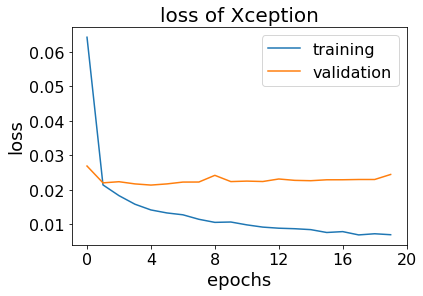

In [12]:
# 绘制训练和验证的损失曲线
plt.plot(history_xception.history['loss'])
plt.plot(history_xception.history['val_loss'])

plt.legend(['training', 'validation'], loc='upper right', fontsize=16)

plt.title('loss of Xception', fontsize=20)
plt.xlabel('epochs', fontsize=18)
plt.ylabel('loss', fontsize=18)

plt.xticks(range(0, 21, 4), fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [14]:
# Xception 
y_pred = model.predict(x_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv('result_csv/sample_submission.csv')

image_generator = ImageDataGenerator()

test_generator = image_generator.flow_from_directory('dataset/test2', target_size=(224, 224), 
                                                     class_mode=None, shuffle=False, batch_size=16)

for i, filename in enumerate(test_generator.filenames):
    idx = filename[filename.find('/')+1 : filename.find('.')]
    df.set_value(int(idx)-1, 'label', y_pred[i])

df.to_csv('result_csv/pred_xception_1.csv', index=False)
# score 0.04448

12500/12500 [==============================] - 0s 18us/step
Found 12500 images belonging to 1 classes.


In [25]:
with h5py.File('extract_features/InceptionResNetV2_gap.h5', 'r') as h:
    x_train = np.array(h['train'])
    x_test = np.array(h['test'])
    y_train = np.array(h['labels'])

x_train, y_train = shuffle(x_train, y_train)
print(x_train.shape, x_test.shape, y_train.shape)

input_tensor = Input(x_train.shape[1:])
x = Dropout(0.2)(input_tensor)
x = Dense(1, activation='sigmoid')(x)

model = Model(input_tensor, x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

hsitory_IRv2 = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

(25000, 1536) (12500, 1536) (25000,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1536)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1537      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 73us/step - loss: 0.0547 - acc: 0.9888 - val_loss: 0.0237 - val_acc: 0.9940
Epoch 2/10
20000/20000 [==============================] - 1s 59us/step - loss: 0.0227 - acc: 0.9942 - val_loss: 0.0195 - val_acc: 0.9948
Epoch 3/10
20000/20000 [===============

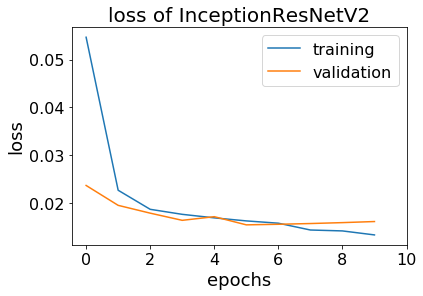

In [27]:
# 绘制训练和验证的损失曲线
plt.plot(hsitory_IRv2.history['loss'])
plt.plot(hsitory_IRv2.history['val_loss'])

plt.legend(['training', 'validation'], loc='upper right', fontsize=16)

plt.title('loss of InceptionResNetV2', fontsize=20)
plt.xlabel('epochs', fontsize=18)
plt.ylabel('loss', fontsize=18)

plt.xticks(range(0, 11, 2), fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [28]:
# InceptionResNetV2
y_pred = model.predict(x_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv('result_csv/sample_submission.csv')

image_generator = ImageDataGenerator()

test_generator = image_generator.flow_from_directory('dataset/test2', target_size=(224, 224), 
                                                     class_mode=None, shuffle=False, batch_size=16)

for i, filename in enumerate(test_generator.filenames):
    idx = filename[filename.find('/')+1 : filename.find('.')]
    df.set_value(int(idx)-1, 'label', y_pred[i])

df.to_csv('result_csv/pred_IRv2_1.csv', index=False)
# score 0.03852

12500/12500 [==============================] - 0s 22us/step
Found 12500 images belonging to 1 classes.


In [15]:
# 模型联结
x_train, x_test = list(), list()
for h5_model in ['Xception_gap.h5', 'InceptionResNetV2_gap.h5']:
    h5_model = 'extract_features/' + h5_model
    with h5py.File(h5_model, 'r') as h:
        x_train.append(np.array(h['train']))
        x_test.append(np.array(h['test']))
        y_train = np.array(h['labels'])
    
x_train = np.hstack(x_train)
x_test = np.hstack(x_test)
x_train, y_train = shuffle(x_train, y_train)
print(x_train.shape, x_test.shape, y_train.shape)

(25000, 3584) (12500, 3584) (25000,)


In [16]:
input_tensor = Input(x_train.shape[1:])
x = Dropout(0.2)(input_tensor)
x = Dense(1, activation='sigmoid')(x)

model = Model(input_tensor, x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3584)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3584)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3585      
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
# 'Xception_gap.h5', 'InceptionResNetV2_gap.h5'
y_pred = model.predict(x_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv('result_csv/sample_submission.csv')

image_generator = ImageDataGenerator()

test_generator = image_generator.flow_from_directory('dataset/test2', target_size=(224, 224), 
                                                     class_mode=None, shuffle=False, batch_size=16)

for i, filename in enumerate(test_generator.filenames):
    idx = filename[filename.find('/')+1 : filename.find('.')]
    df.set_value(int(idx)-1, 'label', y_pred[i])

df.to_csv('result_csv/pred_X_IR.csv', index=False)
# score 0.03872

12500/12500 [==============================] - 0s 26us/step
Found 12500 images belonging to 1 classes.


## Extract features with data augmentation

In [ ]:
# get_model with data augmentation

def get_model_with_da(model, image_size, preprocess_func, model_name):
    # with data augmentation
    # model like vgg16.VGG16
    # image_size: a tuple with image height and width
    # preprocess_func like vgg16.preprocess_input
    # model_name: string of model name
    x = Input(shape=(image_size[0], image_size[1], 3))
    x = Lambda(preprocess_func)(x)
    base_model = model(include_top=False, input_tensor=x, weights='imagenet', pooling='avg')
    
    # augmentation configuration for training
    train_datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    train_generator = train_datagen.flow_from_directory('dataset/train_diff', target_size=image_size, class_mode='binary', shuffle=False, batch_size=16)
    
    # augmentation configuration for testing 
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_directory('dataset/test2', target_size=image_size,  shuffle=False, batch_size=16)

    train = base_model.predict_generator(train_generator)
    test = base_model.predict_generator(test_generator)

    with h5py.File('%s_da_gap.h5' % model_name) as h:
        h.create_dataset('train', data=train)
        h.create_dataset('test', data=test)
        h.create_dataset('labels', data=train_generator.classes)

In [ ]:
# 导出 VGG16 + data augmentation 的model
start_time = time()
get_model_with_da(vgg16.VGG16, (224,224), vgg16.preprocess_input, 'VGG16')
print('VGG16 Time: {}s'.format(round(time() - start_time, 1)))

In [ ]:
# 导出 Xception + data augmentation 的model
start_time = time()
get_model_with_da(xception.Xception, (299,299), xception.preprocess_input, 'Xception')
print('Xception Time: {}s'.format(round(time() - start_time, 1)))

In [ ]:
# 导出 InceptionResNetV2 + data augmentation 的model
start_time = time()
get_model_with_da(inception_resnet_v2.InceptionResNetV2, (299,299), inception_resnet_v2.preprocess_input, 'InceptionResNetV2')
print('InceptionResNetV2 Time: {}s'.format(round(time() - start_time, 1)))

In [2]:
def train_model(features_file):
    # features_file like 'VGG16_gap.h5'
    # 读取模型的特征向量
    with h5py.File(features_file, 'r') as h:
        x_train = np.array(h['train'])
        x_test = np.array(h['test'])
        y_train = np.array(h['labels'])
        
    x_train, y_train = shuffle(x_train, y_train)
    
    # 创建模型
    input_tensor = Input(x_train.shape[1:])
    x = Dropout(0.2)(input_tensor)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(input_tensor, x)
    return model, x_train, y_train, x_test
    

In [3]:
model, x_train, y_train, x_test = train_model('VGG16_da_gap.h5')
print(x_train.shape, x_test.shape, y_train.shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

(25000, 512) (12500, 512) (25000,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
for layer in model.layers:
    print(layer.name)

input_1
dropout_1
dense_1


In [5]:
history_vgg16 = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 84us/step - loss: 0.3178 - acc: 0.9161 - val_loss: 0.0683 - val_acc: 0.9750
Epoch 2/20
20000/20000 [==============================] - 1s 69us/step - loss: 0.1087 - acc: 0.9674 - val_loss: 0.0587 - val_acc: 0.9780
Epoch 3/20
20000/20000 [==============================] - 1s 68us/step - loss: 0.0880 - acc: 0.9710 - val_loss: 0.0494 - val_acc: 0.9800
Epoch 4/20
20000/20000 [==============================] - 1s 70us/step - loss: 0.0762 - acc: 0.9738 - val_loss: 0.0485 - val_acc: 0.9804
Epoch 5/20
20000/20000 [==============================] - 1s 68us/step - loss: 0.0748 - acc: 0.9739 - val_loss: 0.0499 - val_acc: 0.9798
Epoch 6/20
20000/20000 [==============================] - 1s 69us/step - loss: 0.0725 - acc: 0.9752 - val_loss: 0.0744 - val_acc: 0.9742
Epoch 7/20
20000/20000 [==============================] - 1s 71us/step - loss: 0.0711 - acc: 0.9755 - val_loss: 0.0476 - val_acc:

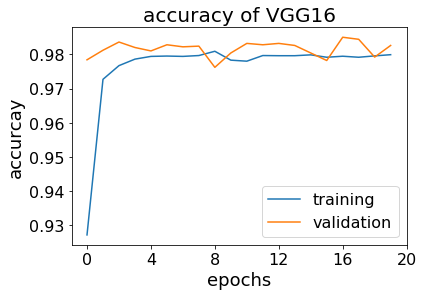

In [5]:
# 绘制训练和验证曲线
plt.plot(history_vgg16.history['acc'])
plt.plot(history_vgg16.history['val_acc'])

plt.legend(['training', 'validation'], loc='lower right', fontsize=16)

plt.title('accuracy of VGG16', fontsize=20)
plt.xlabel('epochs', fontsize=18)
plt.ylabel('accurcay', fontsize=18)

plt.xticks(range(0, 21, 4), fontsize=16)
plt.yticks(fontsize=16)

plt.show()

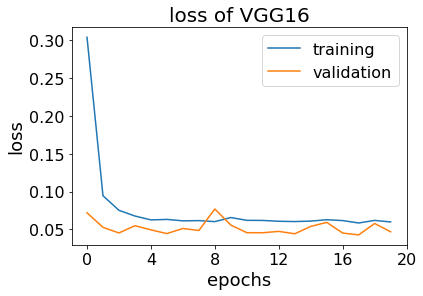

In [7]:
# 绘制训练和验证的损失曲线
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])

plt.legend(['training', 'validation'], loc='upper right', fontsize=16)

plt.title('loss of VGG16', fontsize=20)
plt.xlabel('epochs', fontsize=18)
plt.ylabel('loss', fontsize=18)

plt.xticks(range(0, 21, 4), fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [6]:
# vgg16 
y_pred = model.predict(x_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv('sample_submission.csv')

image_generator = ImageDataGenerator()

test_generator = image_generator.flow_from_directory('dataset/test2', target_size=(224, 224), 
                                                     class_mode=None, shuffle=False, batch_size=16)

for i, filename in enumerate(test_generator.filenames):
    idx = filename[filename.find('/')+1 : filename.find('.')]
    df.set_value(int(idx)-1, 'label', y_pred[i])

df.to_csv('pred_vgg16_1.csv', index=False)
# score 0.06429

12500/12500 [==============================] - 0s 19us/step
Found 12500 images belonging to 1 classes.


## without outliers and withe data augmentation

In [30]:
with h5py.File('extract_features/Xception_da_gap_45.h5', 'r') as h:
    x_train = np.array(h['train'])
    x_test = np.array(h['test'])
    y_train = np.array(h['labels'])

x_train, y_train = shuffle(x_train, y_train)
print(x_train.shape, x_test.shape, y_train.shape)

input_tensor = Input(x_train.shape[1:])
x = Dropout(0.2)(input_tensor)
x = Dense(1, activation='sigmoid')(x)

model = Model(input_tensor, x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

hsitory_xception_45 = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

(24955, 2048) (12500, 2048) (24955,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2049      
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________
None
Train on 19964 samples, validate on 4991 samples
Epoch 1/10
19964/19964 [==============================] - 2s 77us/step - loss: 0.0650 - acc: 0.9876 - val_loss: 0.0290 - val_acc: 0.9924
Epoch 2/10
19964/19964 [==============================] - 1s 55us/step - loss: 0.0226 - acc: 0.9941 - val_loss: 0.0236 - val_acc: 0.9930
Epoch 3/10
19964/19964 [===============

In [31]:
# Xception
y_pred = model.predict(x_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv('result_csv/sample_submission.csv')

image_generator = ImageDataGenerator()

test_generator = image_generator.flow_from_directory('dataset/test2', target_size=(224, 224), 
                                                     class_mode=None, shuffle=False, batch_size=16)

for i, filename in enumerate(test_generator.filenames):
    idx = filename[filename.find('/')+1 : filename.find('.')]
    df.set_value(int(idx)-1, 'label', y_pred[i])

df.to_csv('result_csv/pred_xception_45.csv', index=False)
# score 0.04231

12500/12500 [==============================] - 0s 24us/step
Found 12500 images belonging to 1 classes.


In [2]:
with h5py.File('extract_features/InceptionResNetV2_da_gap_45.h5', 'r') as h:
    x_train = np.array(h['train'])
    x_test = np.array(h['test'])
    y_train = np.array(h['labels'])

x_train, y_train = shuffle(x_train, y_train)
print(x_train.shape, x_test.shape, y_train.shape)

input_tensor = Input(x_train.shape[1:])
x = Dropout(0.2)(input_tensor)
x = Dense(1, activation='sigmoid')(x)

model = Model(input_tensor, x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

hsitory_xception_45 = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

(24955, 1536) (12500, 1536) (24955,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1537      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
Train on 19964 samples, validate on 4991 samples
Epoch 1/10
19964/19964 [==============================] - 1s 72us/step - loss: 0.0596 - acc: 0.9863 - val_loss: 0.0283 - val_acc: 0.9936
Epoch 2/10
19964/19964 [==============================] - 1s 56us/step - loss: 0.0230 - acc: 0.9941 - val_loss: 0.0234 - val_acc: 0.9936
Epoch 3/10
19964/19964 [===============

In [3]:
# InceptionResNetV2
y_pred = model.predict(x_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv('result_csv/sample_submission.csv')

image_generator = ImageDataGenerator()

test_generator = image_generator.flow_from_directory('dataset/test2', target_size=(224, 224), 
                                                     class_mode=None, shuffle=False, batch_size=16)

for i, filename in enumerate(test_generator.filenames):
    idx = filename[filename.find('/')+1 : filename.find('.')]
    df.set_value(int(idx)-1, 'label', y_pred[i])

df.to_csv('result_csv/pred_IRv2_45.csv', index=False)
# score 0.03794

12500/12500 [==============================] - 0s 18us/step
Found 12500 images belonging to 1 classes.


## without validation

In [10]:
with h5py.File('extract_features/InceptionResNetV2_da_gap_45.h5', 'r') as h:
    x_train = np.array(h['train'])
    x_test = np.array(h['test'])
    y_train = np.array(h['labels'])

x_train, y_train = shuffle(x_train, y_train)
print(x_train.shape, x_test.shape, y_train.shape)

input_tensor = Input(x_train.shape[1:])
x = Dropout(0.2)(input_tensor)
x = Dense(1, activation='sigmoid')(x)

model = Model(input_tensor, x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

hsitory_xception_45 = model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1)

(24955, 1536) (12500, 1536) (24955,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1536)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1537      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
24955/24955 [==============================] - 2s 63us/step - loss: 0.0477 - acc: 0.9907
Epoch 2/20
24955/24955 [==============================] - 1s 48us/step - loss: 0.0223 - acc: 0.9941
Epoch 3/20
24955/24955 [==============================] - 1s 48us/step - loss: 0.0206 - acc: 0.9948
Epoch 4/20
24955/24955 [==============================] - 1s 4

In [11]:
# InceptionResNetV2
y_pred = model.predict(x_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv('result_csv/sample_submission.csv')

image_generator = ImageDataGenerator()

test_generator = image_generator.flow_from_directory('dataset/test2', target_size=(224, 224), 
                                                     class_mode=None, shuffle=False, batch_size=16)

for i, filename in enumerate(test_generator.filenames):
    idx = filename[filename.find('/')+1 : filename.find('.')]
    df.set_value(int(idx)-1, 'label', y_pred[i])

df.to_csv('result_csv/pred_IRv2_45_noval.csv', index=False)
# score 0.03822

12500/12500 [==============================] - 0s 22us/step
Found 12500 images belonging to 1 classes.


In [ ]:
# hsitory_X_IR = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

In [ ]:
# ====== without data augmentation
# VGG16 0.08553
# Xception 0.04448
# InceptionResNetV2 0.03852
# Xception + InceptionResNetV2 0.03872

# ====== with data augmentation
# VGG16 0.06429

# ====== without outliers and with data augmentation
# Xception 0.04231
# InceptionResNetV2 0.03794